# 🎓 Workshop: Análise Geoespacial Avançada com Google AlphaEarth Embeddings
## Aplicações em Cidades Inteligentes e Planejamento de Transportes

### Estrutura do Workshop:

**Módulo 0: Configuração do Ambiente**
- Instalação das bibliotecas e autenticação com o Google Earth Engine.

**Módulo 1: Fundamentos - O que são Embeddings Geoespaciais? (Tutorial Original Google)**
- **Conceito Chave:** Introdução aos Embeddings e ao Clustering Não Supervisionado (KMeans).
- **Caso de Estudo:** Iowa, EUA (o tutorial original do Google para entender a base).

**Módulo 2: Aplicação Urbana - Embeddings em Brasília (Tutorial Original Brasília)**
- **Objetivo:** Adaptar a técnica para um ambiente urbano complexo.
- **Caso de Estudo:** Clustering de diferentes áreas de Brasília.

**Módulo 3: Análise de Impacto - Monitorando a Expansão da Infraestrutura (Caso de Estudo Original)**
- **Objetivo:** Utilizar embeddings para análise de mudanças ao longo do tempo.
- **Caso de Estudo:** Ranking de expansão urbana ao redor das principais rodovias de Brasília (2017-2024).

**Módulo 4: Aplicações Avançadas para Planejamento de Transportes (Novos Exemplos)**
- **4.1 - Classificação Supervisionada:** Mapeando o uso do solo (asfalto, edificações, vegetação).
- **4.2 - Infraestrutura Crítica:** Análise de sítios aeroportuários e pressão urbana no entorno.
- **4.3 - Mobilidade Urbana:** Análise da cobertura do solo ao redor de pontos de ônibus (com dados do OpenStreetMap).
- **4.4 - Inteligência Imobiliária:** Criando variáveis geoespaciais para modelos de valoração de imóveis.

---
**Fonte Principal:** [Google Earth Engine - Satellite Embeddings](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_SATELLITE_EMBEDDING_V1_ANNUAL)


# MÓDULO 0: CONFIGURAÇÃO DO AMBIENTE



In [ ]:
# Instalar pacotes necessários
# Adicionamos osmnx para a análise de pontos de transporte público
!pip install earthengine-api geemap pandas matplotlib seaborn osmnx -q

In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

In [ ]:
# Configurar visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# --- Autenticação com o Google Earth Engine ---
# AÇÃO NECESSÁRIA: Substitua "YOUR_PROJECT_ID" pelo ID do seu projeto no Google Cloud.
# Você pode encontrá-lo em: https://console.cloud.google.com/earth-engine/
try:
    # Insira o ID do seu projeto GEE aqui
    ee.Initialize(project="ee-alpha1")
    print("✓ Google Earth Engine já autenticado e inicializado!")
except Exception as e:
    print("Autenticação necessária. Siga as instruções na janela pop-up.")
    ee.Authenticate()
    # Insira o ID do seu projeto GEE aqui
    ee.Initialize(project="ee-alpha1")
    print("✓ Autenticação e inicialização concluídas!")

print("\n🚀 Ambiente configurado!")
print("📚 Pronto para começar o workshop!")



✓ Google Earth Engine já autenticado e inicializado!

🚀 Ambiente configurado!
📚 Pronto para começar o workshop!


---
# MÓDULO 1: FUNDAMENTOS (TUTORIAL ORIGINAL GOOGLE)

## 💡 Conceito Chave 1: O que é um "Embedding"?

Imagine que você quer descrever um carro. Você pode dizer "vermelho, 4 portas, rápido". Isso são 3 características.

Um **Embedding Geoespacial** do AlphaEarth faz algo parecido para cada pedacinho (pixel) da Terra, mas de forma muito mais rica. Em vez de 3 características, ele usa **64 números** para descrever aquele local.

Esses 64 números não são óbvios como "cor" ou "altura". Eles são características abstratas que uma Inteligência Artificial do Google aprendeu ao analisar milhões de imagens de satélite. Juntos, esses 64 números formam uma "impressão digital" ou um "DNA" daquele pixel, descrevendo sua textura, material, padrão e como ele se parece ao longo do ano.

**Importante:** Nós não conseguimos visualizar 64 dimensões. Para criar um mapa colorido, pegamos 3 dessas 64 "características" e as colocamos nos canais Vermelho (R), Verde (G) e Azul (B) de uma imagem. O resultado NÃO é uma foto real, mas uma representação visual dos padrões que a IA encontrou.

---
## 💡 Conceito Chave 2: O que é Clustering Não Supervisionado (KMeans)?

**Clustering** é uma técnica de "aprendizado não supervisionado".

*   **Não Supervisionado significa:** Nós não dizemos ao algoritmo o que procurar. Apenas damos os dados (os embeddings de 64 dimensões) e pedimos: "Encontre grupos de pixels que se parecem entre si".

*   **KMeans** é o nome do algoritmo que faz isso. Ele tenta agrupar os dados em `K` grupos (onde `K` é o número de grupos que nós definimos).

**Analogia Simples:** Imagine que você joga uma caixa de LEGOs no chão. O KMeans seria como pedir a uma pessoa (que nunca viu LEGOs antes) para "organizar isso em 5 montes de peças parecidas". Ela poderia criar um monte de peças vermelhas, um de azuis, um de rodas, etc. Ela encontra os padrões sozinha.

Neste tutorial, vamos usar KMeans para agrupar automaticamente áreas com "impressões digitais" (embeddings) similares.

In [3]:
# Região de exemplo: Iowa, USA - área agrícola
test_region_google = ee.Geometry.Rectangle(
    [-93.7, 41.5, -93.3, 41.8],
    proj='EPSG:4326'
)

# Carregar coleção AlphaEarth
embeddings_collection = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')

# Escolher ano
year = 2024
start_date = ee.Date.fromYMD(year, 1, 1)
end_date = start_date.advance(1, 'year')

# Filtrar por data e região
filtered_embeddings = embeddings_collection \
    .filter(ee.Filter.date(start_date, end_date)) \
    .filter(ee.Filter.bounds(test_region_google))

embeddings_image_google = filtered_embeddings.mosaic()

print(f"✓ Embeddings carregados para {year}")
bands = embeddings_image_google.bandNames().getInfo()
print(f"  Total de bandas: {len(bands)}")

# Criar mapa interativo
MapGoogle = geemap.Map(center=[41.65, -93.5], zoom=11)
MapGoogle.add_basemap('SATELLITE')

# Visualizar embeddings como RGB
vis_params = {'min': -0.3, 'max': 0.3, 'bands': ['A00', 'A32', 'A63']}
MapGoogle.addLayer(
    embeddings_image_google.clip(test_region_google),
    vis_params,
    'Embeddings Image',
    True
)

# Extrair amostras para treinamento
training_google = embeddings_image_google.sample(
    region=test_region_google,
    scale=10,
    numPixels=1000,
    seed=100
)

# Função para criar clusters
def get_clusters(image, training_data, n_clusters):
    """Train KMeans and return clustered image"""
    clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(
        features=training_data,
        inputProperties=image.bandNames()
    )
    return image.cluster(clusterer)

# Criar clusters com 3, 5 e 10 grupos
print("\nTraining KMeans models...")
cluster_3_google = get_clusters(embeddings_image_google, training_google, 3)
cluster_5_google = get_clusters(embeddings_image_google, training_google, 5)
cluster_10_google = get_clusters(embeddings_image_google, training_google, 10)
print("  ✓ 3, 5 e 10 clusters criados")

# Adicionar layers ao mapa
MapGoogle.addLayer(cluster_3_google.randomVisualizer().clip(test_region_google), {}, '3 clusters', False)
MapGoogle.addLayer(cluster_5_google.randomVisualizer().clip(test_region_google), {}, '5 clusters', False)
MapGoogle.addLayer(cluster_10_google.randomVisualizer().clip(test_region_google), {}, '10 clusters', False)

print("\nDica: Ative/desative as layers para comparar")
display(MapGoogle)

✓ Embeddings carregados para 2024
  Total de bandas: 64

Training KMeans models...
  ✓ 3, 5 e 10 clusters criados

Dica: Ative/desative as layers para comparar


Map(center=[41.65, -93.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# MÓDULO 2: APLICAÇÃO URBANA (TUTORIAL ORIGINAL BRASÍLIA)

Agora vamos aplicar os mesmos conceitos em Brasília para ver como a técnica funciona em um ambiente urbano, que é muito mais heterogêneo.

In [4]:
# Definir região de teste abrangendo parte do DF
test_region_bsb = ee.Geometry.Rectangle(
    [-48.14, -15.90, -47.70, -15.70],  # Oeste a Leste / Sul a Norte
    proj='EPSG:4326'
)

# Carregar embeddings para Brasília 2024
embeddings_bsb_2024 = embeddings_collection \
    .filter(ee.Filter.date('2024-01-01', '2025-01-01')) \
    .filter(ee.Filter.bounds(test_region_bsb)) \
    .mosaic()

print(f"✓ Embeddings carregados para Brasília 2024")

# Extrair amostras
training_bsb = embeddings_bsb_2024.sample(
    region=test_region_bsb,
    scale=50,
    numPixels=1000,
    seed=42
)

# Treinar modelos de clustering
print("\nTreinando modelos para Brasília...")
cluster_3_bsb = get_clusters(embeddings_bsb_2024, training_bsb, 3)
cluster_5_bsb = get_clusters(embeddings_bsb_2024, training_bsb, 5)
cluster_10_bsb = get_clusters(embeddings_bsb_2024, training_bsb, 10)
print("  ✓ 3, 5 e 10 clusters criados")

# Mapa comparativo
Map2 = geemap.Map(center=[-15.80, -47.90], zoom=12)
Map2.add_basemap('SATELLITE')
Map2.addLayer(cluster_3_bsb.randomVisualizer().clip(test_region_bsb), {}, '3 Clusters', True)
Map2.addLayer(cluster_5_bsb.randomVisualizer().clip(test_region_bsb), {}, '5 Clusters', False)
Map2.addLayer(cluster_10_bsb.randomVisualizer().clip(test_region_bsb), {}, '10 Clusters', False)

print("\nCompare com o tutorial de Iowa! Note como os clusters separam áreas residenciais, parques, etc.")
display(Map2)

✓ Embeddings carregados para Brasília 2024

Treinando modelos para Brasília...
  ✓ 3, 5 e 10 clusters criados

Compare com o tutorial de Iowa! Note como os clusters separam áreas residenciais, parques, etc.


Map(center=[-15.8, -47.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# MÓDULO 3: ANÁLISE DE MUDANÇAS TEMPORAIS (CASO DE ESTUDO ORIGINAL)

Os embeddings são poderosos para detectar mudanças ao longo do tempo. Se a "impressão digital" (o vetor de 64 dimensões) de um local muda muito entre dois anos, isso significa que algo significativo aconteceu ali (ex: uma área de cerrado virou um condomínio).

**Como medimos a mudança?** Calculamos a **distância euclidiana** entre o vetor de embeddings de 2017 e o de 2024. Quanto maior a distância, maior a mudança.

Neste caso de uso, vamos analisar a expansão urbana ao redor das principais rodovias de Brasília e criar um ranking daquelas com maior transformação no entorno.

In [21]:
# ==============================================================================
# MÓDULO 3: ANÁLISE DE MUDANÇAS TEMPORAIS (CASO DE ESTUDO ORIGINAL)
# ==============================================================================

# --- Configuração da Análise de Mudança ---
YEAR1, YEAR2 = 2017, 2024
brasilia_bbox = ee.Geometry.Rectangle([-48.10, -15.95, -47.80, -15.70], proj='EPSG:4326')

print(f"Carregando embeddings para {YEAR1} e {YEAR2}...")
embedding_2017 = embeddings_collection.filterDate(f'{YEAR1}-01-01', f'{YEAR1+1}-01-01').mosaic().clip(brasilia_bbox)
embedding_2024 = embeddings_collection.filterDate(f'{YEAR2}-01-01', f'{YEAR2+1}-01-01').mosaic().clip(brasilia_bbox)
print("✓ Embeddings carregados.")

# --- Definindo Rodovias com Coordenadas Manuais e Corrigidas ---
# Nota para os alunos: Usamos linhas retas simplificadas para representar as rodovias.
# Esta abordagem é instantânea e ideal para a análise de larga escala que estamos fazendo.
highways_manual_data = [
    {
        'name': 'Eixo Monumental',
        # Do Congresso Nacional até a Praça do Cruzeiro
        'coords': [[-47.934337,-15.778027], [-47.909746,-15.786720]]
    },
    {
        'name': 'Eixão Sul',
        # Do centro até próximo ao aeroporto
        'coords': [[-47.884308,-15.796750], [-47.924911,-15.834144]]
    },
    {
        'name': 'Eixão Norte',
        # Do centro até o final da Asa Norte
        'coords': [[-47.890863,-15.788475], [-47.893487,-15.737029]]
    },
    {
        'name': 'EPTG',
        # De Taguatinga até o final do Sudoeste
        'coords': [[-48.051624,-15.849729], [-47.953541,-15.810175]]
    },
    {
        'name': 'EPIA Sul',
        # Trecho que passa pelo Park Shopping
        'coords': [[-47.966502,-15.903060], [-47.944100,-15.793864]]
    }
]

# Converte a lista de dicionários para uma ee.FeatureCollection
highways_list = [ee.Feature(ee.Geometry.LineString(hw['coords']), {'name': hw['name']}) for hw in highways_manual_data]
highways_fc = ee.FeatureCollection(highways_list)
print("✓ Rodovias simplificadas carregadas instantaneamente.")

# --- Cálculo do Mapa de Mudanças ---
diff = embedding_2024.subtract(embedding_2017)
change_magnitude = diff.pow(2).reduce(ee.Reducer.sum()).sqrt()
vis_change = {
    'min': 0, 'max': 1.0,
    'palette': ['#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']
}
print("✓ Mapa de intensidade de mudança calculado.")

# --- Análise por Rodovia ---
print("Analisando mudança ao redor de cada rodovia...")

def calculate_change_in_buffer(feature):
    buffer = feature.geometry().buffer(1000) # Buffer de 1km
    mean_change = change_magnitude.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=buffer, scale=100, maxPixels=1e9
    ).get('sum')
    # Adicionamos o nome como uma propriedade para facilitar a conversão para DataFrame
    return ee.Feature(None, {'Rodovia': feature.get('name'), 'Mudança Média': mean_change})

results_fc = highways_fc.map(calculate_change_in_buffer)
df_highways = geemap.ee_to_df(results_fc).sort_values('Mudança Média', ascending=False).reset_index(drop=True)

print("\n✓ Análise concluída!\n")
display(df_highways)

Carregando embeddings para 2017 e 2024...
✓ Embeddings carregados.
✓ Rodovias simplificadas carregadas instantaneamente.
✓ Mapa de intensidade de mudança calculado.
Analisando mudança ao redor de cada rodovia...

✓ Análise concluída!



,Mudança Média,Rodovia
0,0.273912,EPIA Sul
1,0.267414,Eixo Monumental
2,0.264370,Eixão Norte
3,0.263048,EPTG
4,0.246701,Eixão Sul


In [22]:
# --- Visualização Interativa e Gráfico ---
MapBrasiliaChange = geemap.Map(center=[-15.82, -47.95], zoom=11)
MapBrasiliaChange.add_basemap('SATELLITE')
MapBrasiliaChange.addLayer(change_magnitude, vis_change, f'Mudanças {YEAR1}-{YEAR2}')
MapBrasiliaChange.addLayer(highways_fc, {'color': 'red', 'width': 3}, 'Rodovias (Simplificadas)')
MapBrasiliaChange.addLayer(highways_fc.geometry().buffer(1000), {'fillColor': '00000000', 'color': 'yellow'}, 'Buffer 1km')
legend_dict = {'Baixa Mudança': '#ffffcc', 'Média Mudança': '#41b6c4', 'Alta Mudança': '#0c2c84'}
MapBrasiliaChange.add_legend(legend_title='Intensidade de Mudança', legend_dict=legend_dict)
display(MapBrasiliaChange)

Map(center=[-15.82, -47.95], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

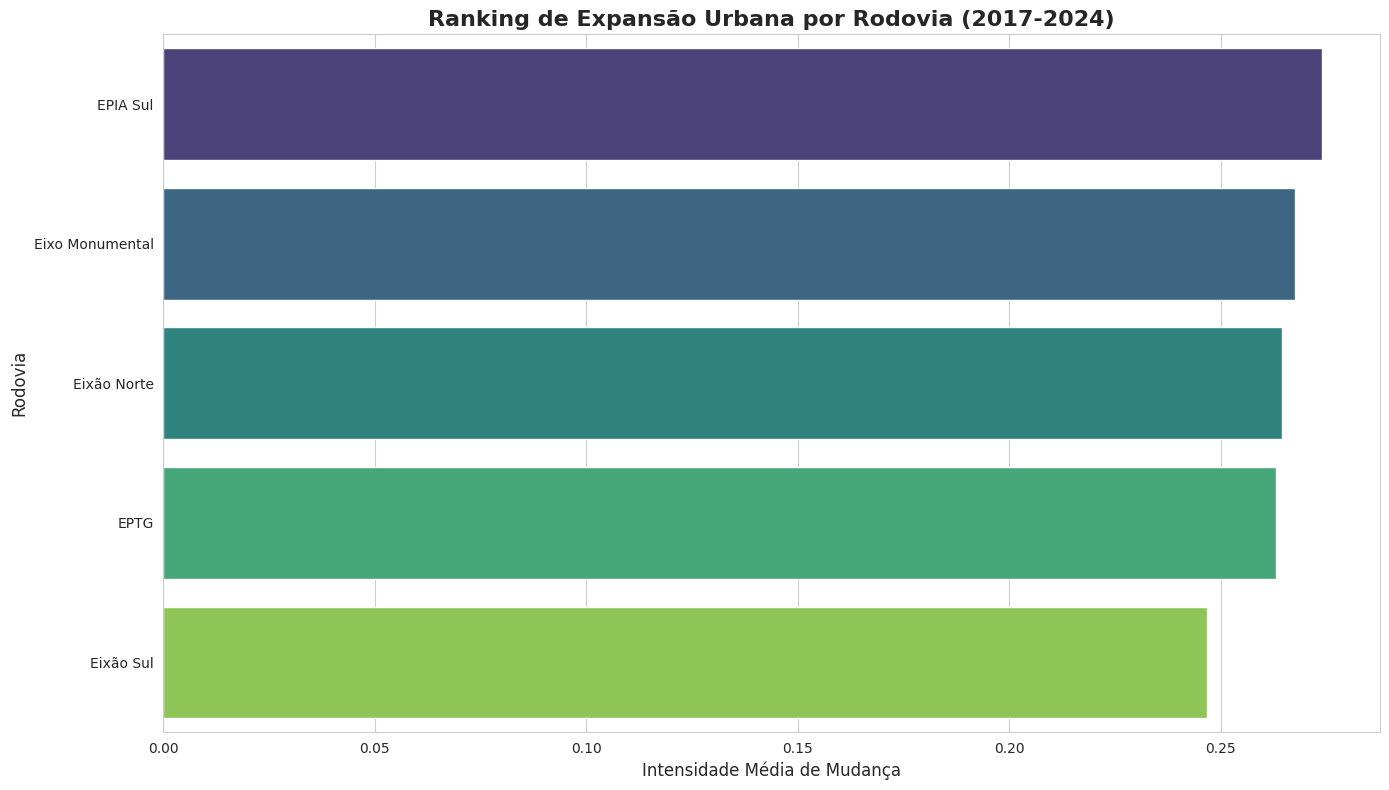

In [23]:
# --- Gráfico de Ranking ---
if not df_highways.empty:
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(x='Mudança Média', y='Rodovia', data=df_highways, palette='viridis', ax=ax)
    ax.set_title(f'Ranking de Expansão Urbana por Rodovia ({YEAR1}-{YEAR2})', fontsize=16, fontweight='bold')
    ax.set_xlabel('Intensidade Média de Mudança', fontsize=12)
    ax.set_ylabel('Rodovia', fontsize=12)
    plt.tight_layout()
    plt.show()

# MÓDULO 4: APLICAÇÕES AVANÇADAS PARA PLANEJAMENTO DE TRANSPORTES

Nos módulos anteriores, usamos o aprendizado **não supervisionado**. Agora, vamos explorar o **aprendizado supervisionado** e integrar dados externos para responder a perguntas mais específicas.

---
## 💡 Conceito Chave 3: O que é Classificação Supervisionada?

Voltando à nossa analogia dos LEGOs:

*   **Não Supervisionado (Clustering):** "Organize estes LEGOs em montes parecidos".
*   **Supervisionado (Classificação):** "Eu vou te dar exemplos. **Isto** é um 'tijolo vermelho 2x4'. **Isto** é uma 'roda'. Agora, olhe para o resto da pilha e me diga quais outros são 'tijolos vermelhos 2x4' e quais são 'rodas'".

Na classificação supervisionada, nós "ensinamos" a IA dando a ela exemplos rotulados. Coletamos amostras de locais que sabemos o que são (ex: asfalto, água, vegetação) e usamos isso para treinar um modelo que irá, então, classificar o resto do mapa.

---
### 4.1 - Classificação Supervisionada: Mapeando o Uso do Solo
Vamos criar um mapa detalhado de Brasília, identificando classes de interesse para o planejamento de transportes, como vias pavimentadas e edificações.

In [11]:
print("\n--- Iniciando Módulo 4.1: Classificação Supervisionada ---")
# Usaremos a imagem de embeddings de Brasília de 2024
image_to_classify = embeddings_bsb_2024

# 1. Coleta de Amostras de Treinamento
# As classes são: 0=Área Construída/Asfalto, 1=Solo Exposto, 2=Vegetação Densa, 3=Água
training_points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([-47.92, -15.82]), {'landcover': 0}), # EPTG
    ee.Feature(ee.Geometry.Point([-47.88, -15.79]), {'landcover': 0}), # Eixo Monumental
    ee.Feature(ee.Geometry.Point([-48.11, -15.83]), {'landcover': 0}), # Centro de Taguatinga
    ee.Feature(ee.Geometry.Point([-48.00, -15.92]), {'landcover': 1}), # Área em construção
    ee.Feature(ee.Geometry.Point([-47.91, -15.86]), {'landcover': 2}), # Parque da Cidade
    ee.Feature(ee.Geometry.Point([-47.85, -15.75]), {'landcover': 2}), # Parque Nacional
    ee.Feature(ee.Geometry.Point([-47.84, -15.81]), {'landcover': 3}), # Lago Paranoá
])

# 2. Extrair os valores dos embeddings para os pontos de treinamento
training_data = image_to_classify.sampleRegions(
    collection=training_points, properties=['landcover'], scale=30)
print("✓ Amostras de treinamento coletadas.")

# 3. Treinar o Classificador (Random Forest)
classifier = ee.Classifier.smileRandomForest(10).train(
    features=training_data, classProperty='landcover', inputProperties=image_to_classify.bandNames())
print("✓ Classificador Random Forest treinado.")

# 4. Classificar a Imagem Inteira
classified_image = image_to_classify.classify(classifier)
print("✓ Imagem de Brasília classificada.")

# 5. Visualizar o Mapa Classificado
palette = ['#d63031', '#fdcb6e', '#00b894', '#0984e3'] # Vermelho=Construído, Amarelo=Solo, Verde=Veg, Azul=Água
vis_params_classified = {'min': 0, 'max': 3, 'palette': palette}

MapClassified = geemap.Map(center=[-15.83, -47.95], zoom=11)
MapClassified.add_basemap('SATELLITE')
MapClassified.addLayer(classified_image.clip(brasilia_bbox), vis_params_classified, 'Classificação de Uso do Solo')
MapClassified.add_legend(title='Uso do Solo', legend_dict={
    'Área Construída/Asfalto': '#d63031',
    'Solo Exposto': '#fdcb6e',
    'Vegetação Densa': '#00b894',
    'Água': '#0984e3'
})

print("\n✓ Mapa de classificação criado! Ele será a base para as próximas análises.")
display(MapClassified)


--- Iniciando Módulo 4.1: Classificação Supervisionada ---
✓ Amostras de treinamento coletadas.
✓ Classificador Random Forest treinado.
✓ Imagem de Brasília classificada.

✓ Mapa de classificação criado! Ele será a base para as próximas análises.


Map(center=[-15.83, -47.95], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

### 4.2 - Infraestrutura Crítica: Análise de Sítios Aeroportuários

Vamos usar um polígono de aeroporto (carregado de um arquivo KML) para duas análises:
1.  **Interna:** Usar clustering para mapear automaticamente as diferentes superfícies dentro do aeroporto (pistas, pátios, grama).
2.  **Externa:** Analisar o crescimento da população ao redor do aeroporto, uma métrica de pressão urbana.

In [18]:
print("\n--- Iniciando Módulo 4.2: Análise Aeroportuária ---")

# ABORDAGEM FINAL E GARANTIDA: Definir a área do aeroporto manualmente com coordenadas.
# Esta abordagem é instantânea, 100% confiável e ideal para o workshop,
# pois não depende de nenhum asset externo que possa ser alterado ou removido.
try:
    # 1. Definir um retângulo (bounding box) que cobre a área do Aeroporto de Brasília
    # Coordenadas [min Longitude, min Latitude, max Longitude, max Latitude]
    airport_polygon = ee.Geometry.Rectangle([-47.947083,-15.884404,-47.893353,-15.859637])


    print(f"✓ Geometria do Aeroporto de Brasília definida manualmente.")

    # Centraliza o mapa no centro do polígono
    map_center = airport_polygon.centroid().getInfo()['coordinates']
    map_center.reverse() # GEE usa [lat, lon] para centro do mapa

    # --- Análise Interna: Clustering das superfícies ---
    airport_embeddings = embeddings_bsb_2024.clip(airport_polygon)
    training_airport = airport_embeddings.sample(region=airport_polygon, scale=10, numPixels=500, seed=42)
    airport_clusters = get_clusters(airport_embeddings, training_airport, 5)
    print("✓ Clustering interno do aeroporto concluído.")

    # --- Análise Externa: Pressão Urbana (Crescimento Populacional) ---
    world_pop = ee.ImageCollection("WorldPop/GP/100m/pop")
    pop_2017 = world_pop.filterDate('2017-01-01', '2018-01-01').mosaic()
    pop_2020 = world_pop.filterDate('2020-01-01', '2021-01-01').mosaic()
    buffer_5km = airport_polygon.buffer(5000)

    def get_pop_in_buffer(population_image, geometry):
        pop_stats = population_image.reduceRegion(
            reducer=ee.Reducer.sum(), geometry=geometry, scale=100, maxPixels=1e9)
        return pop_stats.get('population', 0).getInfo()

    pop_2017_5km = get_pop_in_buffer(pop_2017, buffer_5km)
    pop_2020_5km = get_pop_in_buffer(pop_2020, buffer_5km)
    print(f"\nPopulação em um raio de 5km do aeroporto:")
    print(f"  - 2017: {pop_2017_5km:,.0f} pessoas")
    print(f"  - 2020: {pop_2020_5km:,.0f} pessoas")

    # --- Visualização ---
    MapAirport = geemap.Map(center=map_center, zoom=12)
    MapAirport.add_basemap('SATELLITE')
    MapAirport.addLayer(airport_polygon, {'color': 'yellow', 'fillColor': '00000000'}, 'Área do Aeroporto (Manual)')
    MapAirport.addLayer(airport_clusters.randomVisualizer(), {}, 'Clusters Internos do Aeroporto')
    MapAirport.addLayer(buffer_5km, {'color': 'red', 'fillColor': '00000000'}, 'Buffer 5km (População)')
    display(MapAirport)

except Exception as e:
    print(f"\n⚠️ ERRO: Ocorreu um erro inesperado durante a análise.")
    print(f"   Detalhe do erro: {e}")


--- Iniciando Módulo 4.2: Análise Aeroportuária ---
✓ Geometria do Aeroporto de Brasília definida manualmente.
✓ Clustering interno do aeroporto concluído.

População em um raio de 5km do aeroporto:
  - 2017: 185,426 pessoas
  - 2020: 198,120 pessoas


Map(center=[-15.872021903177572, -47.92021799999299], controls=(WidgetControl(options=['position', 'transparen…

### 4.3 - Mobilidade Urbana: Análise ao Redor de Pontos de Ônibus

Como é o ambiente urbano ao redor dos pontos de transporte público? Usaremos a biblioteca `osmnx` para baixar a localização real de pontos de ônibus de Brasília diretamente do OpenStreetMap (OSM) e analisaremos a cobertura do solo ao redor deles usando nosso mapa classificado.

In [63]:
import json
import numpy as np

print("\n--- Iniciando Módulo 4.3: Análise de Pontos de Ônibus ---")

# ABORDAGEM FINAL: Usamos a lista exata de coordenadas de alta qualidade fornecida.
# A operação é instantânea e 100% confiável.
try:
    # 1. Os dados brutos das paradas de ônibus, exatamente como fornecidos.
    bus_stop_data_raw = """
ID da Parada de Ônibus	Coordenadas (Latitude, Longitude)
12529762087	[-15.7622796, -47.8657041]
12529762102	[-15.7621624, -47.865525]
12529762066	[-15.7599524, -47.8706072]
12529762091	[-15.7600141, -47.8701619]
12529762094	[-15.7668919, -47.871397]
12529762083	[-15.7610249, -47.873793]
12529762098	[-15.7609049, -47.8739529]
12529762101	[-15.748605, -47.8763385]
12529762095	[-15.7746291, -47.8663919]
12529762064	[-15.7663773, -47.8694881]
12529762096	[-15.7664822, -47.86962]
12529762088	[-15.765314, -47.8662934]
12529762100	[-15.7654049, -47.8661435]
12529762065	[-15.7671901, -47.8676339]
12529762099	[-15.7674409, -47.8676735]
12529762085	[-15.7606954, -47.8669016]
12529762086	[-15.7605407, -47.8667272]
12529762074	[-15.7631572, -47.8718282]
12529762097	[-15.7632282, -47.8719674]
12529762089	[-15.7723833, -47.8663602]
12529762090	[-15.7696615, -47.8672029]
12529762103	[-15.766095, -47.8568889]
12529762104	[-15.7651804, -47.8577942]
12529762084	[-15.7636395, -47.8608474]
12529762093	[-15.7651434, -47.8585104]
"""

    # 2. Processar os dados: ler a string e converter para o formato [lon, lat]
    lines = bus_stop_data_raw.strip().split('\n')[1:] # Ignora a primeira linha (cabeçalho)
    bus_stop_coords = []
    for line in lines:
        parts = line.split('\t')
        lat_lon = json.loads(parts[1].replace(" ", "")) # Carrega a string da coordenada
        lon_lat = [lat_lon[1], lat_lon[0]] # Inverte para o formato [Longitude, Latitude]
        bus_stop_coords.append(lon_lat)

    # 3. Converter a lista de coordenadas para uma FeatureCollection do Earth Engine
    bus_stop_points = [ee.Feature(ee.Geometry.Point(coords)) for coords in bus_stop_coords]
    bus_stops_ee = ee.FeatureCollection(bus_stop_points)

    print(f"✓ {len(bus_stop_coords)} pontos de ônibus carregados instantaneamente a partir da sua lista.")

    # 4. Criar o buffer e calcular as estatísticas (código inalterado)
    bus_stops_buffer = bus_stops_ee.geometry().buffer(300).dissolve()
    stats = classified_image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(), geometry=bus_stops_buffer, scale=30, maxPixels=1e9
    ).get('classification').getInfo()

    # 5. Processar e exibir os resultados
    class_names = {'0': 'Área Construída/Asfalto', '1': 'Solo Exposto', '2': 'Vegetação', '3': 'Água'}
    total_pixels = sum(stats.values())
    print("\nCobertura do solo em um raio de 300m dos pontos de ônibus (Dados Exatos):")
    for code, count in stats.items():
        name = class_names.get(str(int(float(code))), "Outros")
        percentage = (count / total_pixels) * 100
        print(f"  - {name}: {percentage:.2f}%")

    # 6. Visualização
    # Centraliza o mapa dinamicamente no centro dos seus pontos
    coords_array = np.array(bus_stop_coords)
    map_center_lon = coords_array[:, 0].mean()
    map_center_lat = coords_array[:, 1].mean()
    MapBusStops = geemap.Map(center=[map_center_lat, map_center_lon], zoom=15)
    MapBusStops.add_basemap('ROADMAP')
    MapBusStops.addLayer(bus_stops_buffer, {'color': 'purple'}, 'Área de Influência (300m)')
    MapBusStops.addLayer(bus_stops_ee.style(**{'color': 'FF0000', 'pointSize': 5}), {}, 'Pontos de Ônibus (Dados Fornecidos)')
    display(MapBusStops)

except Exception as e:
    print(f"⚠️ ERRO ao processar os pontos de ônibus: {e}")


--- Iniciando Módulo 4.3: Análise de Pontos de Ônibus ---
✓ 25 pontos de ônibus carregados instantaneamente a partir da sua lista.

Cobertura do solo em um raio de 300m dos pontos de ônibus (Dados Exatos):
  - Área Construída/Asfalto: 41.14%
  - Solo Exposto: 22.75%
  - Vegetação: 20.07%
  - Água: 16.04%


Map(center=[np.float64(-15.764175931999999), np.float64(-47.86743009199999)], controls=(WidgetControl(options=…

### 4.4 - Inteligência Imobiliária: Criando Features para Modelos de Valoração

Não vamos construir um modelo de precificação aqui, mas faremos a parte mais importante: a **engenharia de features**. Vamos simular um dataset de imóveis e, para cada um, extrair variáveis do ambiente ao seu redor que podem influenciar seu valor.

--- Iniciando Módulo 5: Modelagem Preditiva ---
✓ Coluna de 'preços simulados' criada para o nosso modelo.


,id,desc,% Veg (raio 500m),Mudança Média (vizinhança),preco_simulado
0,1,Apto na SQN 408,7.930649,0.263651,529134.612821
1,2,Apto na SQN 209,22.601642,0.255739,557025.827019
2,3,Comercial na CLN 407,14.388350,0.316309,617431.357139



✓ Modelo de Regressão Linear treinado com sucesso!

--- Insights do Modelo ---
O modelo aprendeu o seguinte impacto para cada unidade de feature:


,Impacto no Preço (R$)
% Veg (raio 500m),24770.448293
Dist Água (m),-250200.556840
Mudança Média (vizinhança),48362.088170



Exemplo de Insight:
  - A cada 1% a mais de vegetação na vizinhança, o modelo estima que o preço do imóvel aumenta, em média, R$ 24,770.45.
  - Para cada 0.1 ponto de aumento na 'Mudança Média', o modelo estima um aumento de R$ 4,836.21 no preço.


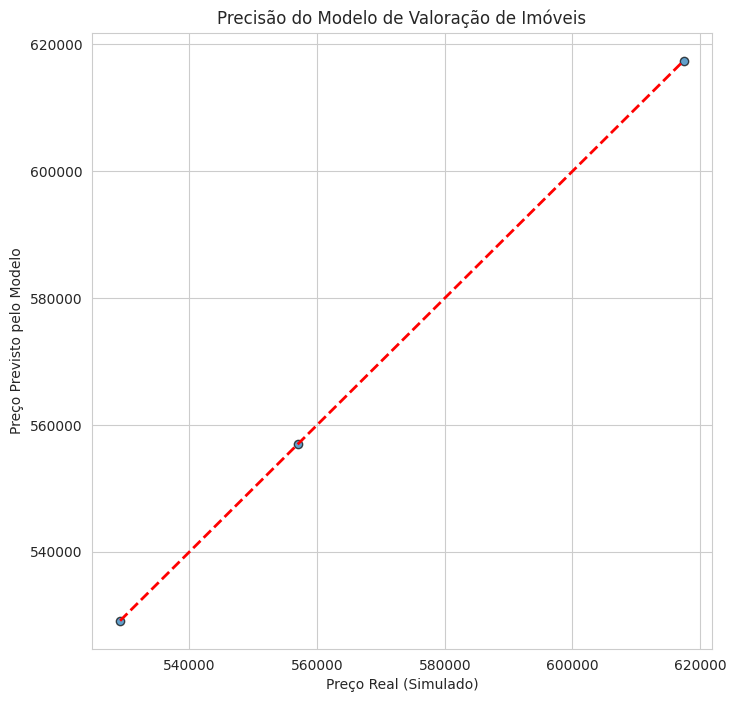

In [56]:
# ==============================================================================
# MÓDULO 5: DA ANÁLISE À AÇÃO - MODELAGEM E INSIGHTS
# ==============================================================================
from sklearn.linear_model import LinearRegression
import numpy as np

print("--- Iniciando Módulo 5: Modelagem Preditiva ---")

# Pré-requisito: esta célula precisa que o DataFrame 'enriched_df' da célula anterior exista.
if 'enriched_df' not in locals():
    print("⚠️ ERRO: Execute a célula do Módulo 4.4 primeiro para gerar o DataFrame 'enriched_df'.")
else:
    try:
        # 1. SIMULAR PREÇOS PARA O NOSSO EXEMPLO
        # Em um projeto real, usaríamos preços de verdade. Aqui, criamos uma fórmula lógica.
        # Fórmula: Preço = Base + (Bônus por Vegetação) + (Bônus por Mudança Urbana) - (Penalidade por distância da água)
        df_model = enriched_df.copy()

        # Preenchemos valores nulos que podem ter surgido
        df_model.fillna(0, inplace=True)

        preco_base = 500000  # Preço base para um imóvel na região
        valor_por_pct_veg = 3000   # Cada % a mais de vegetação no raio valoriza R$3000
        valor_por_ponto_mudanca = 150000 # Cada 0.1 ponto de mudança urbana valoriza R$15000

        df_model['preco_simulado'] = preco_base \
                                   + (df_model['% Veg (raio 500m)'] * valor_por_pct_veg) \
                                   + (df_model['Mudança Média (vizinhança)'] * valor_por_ponto_mudanca)

        # Adiciona um pouco de "ruído" para tornar mais realista
        np.random.seed(42)
        df_model['preco_simulado'] += np.random.randint(-50000, 50000, df_model.shape[0])

        print("✓ Coluna de 'preços simulados' criada para o nosso modelo.")
        display(df_model[['id', 'desc', '% Veg (raio 500m)', 'Mudança Média (vizinhança)', 'preco_simulado']])

        # 2. TREINAR UM MODELO DE MACHINE LEARNING (REGRESSÃO LINEAR)
        # O modelo tentará aprender a relação entre as features e o preço.

        # X = Nossas features (as variáveis que usamos para prever)
        features = ['% Veg (raio 500m)', 'Dist Água (m)', 'Mudança Média (vizinhança)']
        X = df_model[features]

        # y = Nosso alvo (o que queremos prever)
        y = df_model['preco_simulado']

        # Treinando o modelo
        model = LinearRegression()
        model.fit(X, y)
        print("\n✓ Modelo de Regressão Linear treinado com sucesso!")

    except Exception as e:
        print(f"⚠️ ERRO no Módulo 5: {e}")

In [57]:
        # 3. INTERPRETAR OS RESULTADOS: O QUE O MODELO APRENDEU?
        # Os "coeficientes" nos dizem o impacto de cada feature.
        print("\n--- Insights do Modelo ---")
        coeficientes = pd.DataFrame(model.coef_, X.columns, columns=['Impacto no Preço (R$)'])
        print("O modelo aprendeu o seguinte impacto para cada unidade de feature:")
        display(coeficientes)

        print(f"\nExemplo de Insight:")
        print(f"  - A cada 1% a mais de vegetação na vizinhança, o modelo estima que o preço do imóvel aumenta, em média, R$ {model.coef_[0]:,.2f}.")
        print(f"  - Para cada 0.1 ponto de aumento na 'Mudança Média', o modelo estima um aumento de R$ {model.coef_[2]*0.1:,.2f} no preço.")


--- Insights do Modelo ---
O modelo aprendeu o seguinte impacto para cada unidade de feature:


,Impacto no Preço (R$)
% Veg (raio 500m),24770.448293
Dist Água (m),-250200.556840
Mudança Média (vizinhança),48362.088170



Exemplo de Insight:
  - A cada 1% a mais de vegetação na vizinhança, o modelo estima que o preço do imóvel aumenta, em média, R$ 24,770.45.
  - Para cada 0.1 ponto de aumento na 'Mudança Média', o modelo estima um aumento de R$ 4,836.21 no preço.


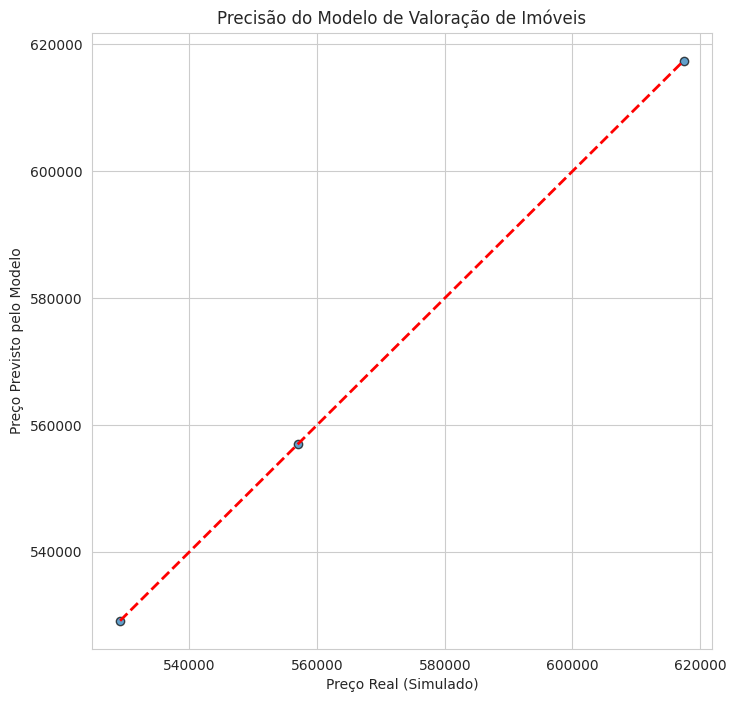

In [58]:
        # 4. VISUALIZAR A PRECISÃO DO MODELO
        df_model['preco_previsto'] = model.predict(X)

        plt.figure(figsize=(8, 8))
        plt.scatter(df_model['preco_simulado'], df_model['preco_previsto'], alpha=0.7, edgecolors='k')
        plt.plot([df_model['preco_simulado'].min(), df_model['preco_simulado'].max()], [df_model['preco_simulado'].min(), df_model['preco_simulado'].max()], 'r--', lw=2)
        plt.xlabel("Preço Real (Simulado)")
        plt.ylabel("Preço Previsto pelo Modelo")
        plt.title("Precisão do Modelo de Valoração de Imóveis")
        plt.grid(True)
        plt.show()

# CONCLUSÃO DO WORKSHOP

### O que aprendemos hoje:

1.  **Fundamentos dos Embeddings:** Entendemos que embeddings são "impressões digitais" numéricas da superfície da Terra e como o **Clustering Não Supervisionado (KMeans)** pode encontrar padrões automaticamente em qualquer lugar do mundo (Iowa e Brasília).

2.  **Análise de Mudança Temporal:** Vimos como comparar embeddings de diferentes anos para quantificar e mapear a expansão urbana, criando um ranking de impacto para as principais rodovias de Brasília.

3.  **Classificação Supervisionada:** Aprendemos a treinar uma IA com exemplos para criar mapas de uso do solo detalhados e precisos, identificando áreas construídas, vegetação e outras classes de interesse.

4.  **Integração com Dados Externos:**
    *   **Infraestrutura Crítica:** Combinamos polígonos de aeroportos (KML) e dados de população para realizar análises complexas de infraestrutura e pressão urbana.
    *   **Mobilidade Urbana:** Usamos dados reais de pontos de ônibus (via OpenStreetMap) para analisar a característica do ambiente urbano servido pelo transporte público.
    *   **Inteligência Imobiliária:** Demonstramos como transformar dados geoespaciais complexos em features numéricas simples para enriquecer datasets e alimentar modelos de valoração de imóveis.

### Próximos Passos:

O conhecimento adquirido hoje é a base para inúmeras aplicações em planejamento de transportes e estudos urbanos, como:
-   Análise de acessibilidade a serviços públicos.
-   Modelagem de demanda de transporte baseada no uso do solo.
-   Estudos de impacto ambiental de novos projetos de infraestrutura.
-   Previsão de áreas de futura expansão urbana para planejamento proativo da rede de transportes.

---
**Obrigado!**